In [1]:
import xarray as xr
import os
import pandas as pd
import tqdm
import numpy as np
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import cmocean

from collections import OrderedDict
from itertools import product
import math
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline

#bootstrap stuff
import dask
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
import random as rd
from tqdm import tqdm

#    from IPython.core.debugger import Pdb; Pdb().set_trace()


In [59]:
# parameters cell
input_paths = ['/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links/','/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/PICT/outdata/oifs/links/']

input_names = ['HIST','PICT']

exps = range(10, 15)
figsize=(6, 4.5)
dpi = 300
ofile = None
res = [720, 360]
'''
variable = ['PRECIP']
levels = [-20,-15,-10,-5,-1,1,5,10,15,20]
title = 'Precipitation anomaly'
accumulation_factor=86400
colormap=plt.cm.PuOr
unit='mm/day'
'''
'''
variable = ['T2M']
levels = [-15,-8.0,-5.0,-3.0,-2.0,-1.0,-.6,-.2,.2,.6,1.0,2.0,3.0,5.0,8.0,15]
title = 'Near surface (2m) air temperature anomaly'
accumulation_factor=1
colormap=plt.cm.PuOr_r
unit='°C'
'''
'''
variable = ['SKT']
levels = [-15,-8.0,-5.0,-3.0,-2.0,-1.0,-.6,-.2,.2,.6,1.0,2.0,3.0,5.0,8.0,15]
title = 'Sea and land surface temperature anomaly'
accumulation_factor=1
colormap=plt.cm.PuOr_r
unit='°C'
'''

variable = ['U10M']
levels = [-1.0,-0.7,-0.5,-0.2,-0.1,0.1,.2,.5,0.7,1.0]
title = '10m eastward wind anonmaly'
accumulation_factor=1
colormap=plt.cm.PuOr_r
unit='m/s'
'''
variable = ['V10M']
levels = [-3.0,-2.0,-1.0,-.6,-.2,.2,.6,1.0,2.0,3.0]
title = '10m northward wind anonmaly'
accumulation_factor=1
colormap=plt.cm.PuOr_r
unit='m/s'
'''


contour_outline_thickness = 0

In [44]:
# Set number of columns, in case of multiple variables
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [45]:
# Calculate Root Mean Square Deviation (RMSD)
def rmsd(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [46]:
# Mean Deviation
def md(predictions, targets):
    return (predictions - targets).mean()


In [48]:
# Load model data

data = OrderedDict()
for exp_path, exp_name  in zip(input_paths, input_names):
    data[exp_name] = {}
    for v in variable:        
        paths = []
        data[exp_name][v] = []
        path = exp_path+variable[0]+'_last25y.nc'
        data[exp_name][v].append(cdo.yearmean(input="-remapcon,r"+str(res[0])+"x"+str(res[1])+" "+str(path),returnArray=v)*accumulation_factor)



In [49]:
def resample(xyobs,n,m):
    xstar = []
    ystar = []
    for ni in range(n):
        r = rd.randrange(0, xyobs.shape[0])
        xstar.append(xyobs[r])
    for mi in range(m):
        r = rd.randrange(0, xyobs.shape[0])
        ystar.append(xyobs[r])
    xbarstar = np.mean(np.asarray(xstar),axis=0)
    ybarstar = np.mean(np.asarray(ystar),axis=0)
    t = xbarstar - ybarstar
    return t

def bootstrap(xyobs, data1, data2):
    tstarobs = np.asarray(data2 - data1)
    tstar = []
    ta = []
    pvalue = []
    n = xyobs.shape[0]//2
    m = xyobs.shape[0]//2
    B = 20000

    for bi in tqdm(range(B)):
        t = dask.delayed(resample)(xyobs,n,m)
        ta.append(t)
    with ProgressBar():
        tstar = dask.compute(ta)
    tstar = np.squeeze(np.asarray(tstar), axis = 0)
    pvalue = np.empty((tstarobs.shape[0],tstarobs.shape[1]))
    for lat in tqdm(range(0,tstarobs.shape[0])):
        for lon in range(0,tstarobs.shape[1]):
            p1 = tstar[:,lat,lon][tstar[:,lat,lon] >= tstarobs[lat,lon]].shape[0]/B
            p2 = tstar[:,lat,lon][tstar[:,lat,lon] >= -tstarobs[lat,lon]].shape[0]/B
            pvalue[lat,lon] = min(p1,p2)
    return pvalue

In [50]:
# Bootstrap significance test
xyobs = np.asarray(np.concatenate([np.squeeze(data[input_names[0]][variable[0]]),np.squeeze(data[input_names[1]][variable[0]])]))
mean_hist=np.mean(np.squeeze(data[input_names[0]][variable[0]]),axis=0)
mean_pict=np.mean(np.squeeze(data[input_names[1]][variable[0]]),axis=0)
                                   
pvalue = bootstrap(xyobs, mean_hist, mean_pict)
data_sig = np.greater(pvalue, 0.025)

lon = np.arange(0, 360, 0.5)
lat = np.arange(-90, 90, 0.5)
data_sig, lon = add_cyclic_point(data_sig, coord=lon)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:01<00:00, 13022.33it/s]


[########################################] | 100% Completed | 48.7s


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [01:25<00:00,  4.23it/s]


(360, 720)
(360, 721)


convert: unable to open image 'U10M_PICT-HIST': No such file or directory @ error/blob.c/OpenBlob/3533.
convert: no decode delegate for this image format `' @ error/constitute.c/ReadImage/572.
convert: no images defined `U10M_PICT-HIST_trimmed.png' @ error/convert.c/ConvertImageCommand/3322.
mv: cannot stat 'U10M_PICT-HIST_trimmed.png': No such file or directory


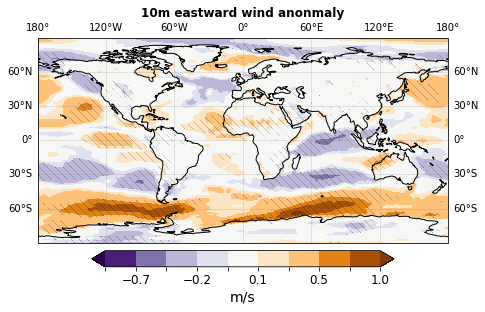

In [60]:
data_model = OrderedDict()
data_model_mean = OrderedDict()


for exp_name in input_names:
    data_model[exp_name] = np.squeeze(data[exp_name][variable[0]]) 
    data_model_mean[exp_name] = data_model[exp_name]
    if len(np.shape(data_model_mean[exp_name])) > 2:
        data_model_mean[exp_name] = np.mean(data_model_mean[exp_name],axis=0)
  

print(np.shape(data_model_mean[exp_name]))

for exp_name in input_names:
    lon = np.arange(0, 360, 0.5)
    lat = np.arange(-90, 90, 0.5)
    data_model_mean[exp_name], lon = add_cyclic_point(data_model_mean[exp_name], coord=lon)

print(np.shape(data_model_mean[exp_name]))


#rmsdval = rmsd(data_model_mean[exp_name],data_reanalysis_mean)
#mdval = md(data_model_mean[exp_name],data_reanalysis_mean)


nrows, ncol = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0

axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
axes[i].add_feature(cfeature.COASTLINE,zorder=3)


imf=plt.contourf(lon, lat, data_model_mean[input_names[0]]-
                data_model_mean[input_names[1]], cmap=colormap, 
                 levels=levels, extend='both',
                 transform=ccrs.PlateCarree(),zorder=1)

plt.rcParams['hatch.linewidth']=0.15
cs = plt.contourf(lon, lat, data_sig, 3 , hatches=['\\\\\\', ''],  alpha=0)


axes[i].set_xlabel('Simulation Year')
axes[i].set_title(title,fontweight="bold")
plt.tight_layout() 
gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.2, linestyle='-')
gl.xlabels_bottom = False

if variable[0] == 'T2M':
    plt.axhline(y=65, color='black', linestyle='-',alpha=.4)
    
    # Calculate AAI
    arctic_mean_pict=np.mean(data_model_mean[input_names[1]][310:,:])
    arctic_mean_hist=np.mean(data_model_mean[input_names[0]][310:,:])
    glob_mean_pict=np.mean(data_model_mean[input_names[1]][:,:])
    glob_mean_hist=np.mean(data_model_mean[input_names[0]][:,:])
    Arctic_Amplification_Index = (arctic_mean_hist-arctic_mean_pict)/(glob_mean_hist-glob_mean_pict)
    print("AAI:",Arctic_Amplification_Index)
    #plt.text(185, 90, 'AAI:')
    #plt.text(185, 70, str(round(Arctic_Amplification_Index,2)))
    props = dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7)
    textstr='AAI:'+str(round(Arctic_Amplification_Index,2))
    axes[i].text(0.86, 0.98, textstr, transform=axes[i].transAxes, fontsize=13,
        verticalalignment='top', bbox=props, zorder=4)


cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
cbar_ax_abs.tick_params(labelsize=12)
cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=levels)
cb.set_label(label=unit, size='14')
cb.ax.tick_params(labelsize='12')
#plt.text(5, 168, r'rmsd='+str(round(rmsdval,3)))
#plt.text(-7.5, 168, r'bias='+str(round(mdval,3)))


    
for label in cb.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ofile=variable[0]+'_'+input_names[1]+'-'+input_names[0]
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')

(360, 720)
(360, 721)


convert: unable to open image 'U10M_PICT-HIST_rel': No such file or directory @ error/blob.c/OpenBlob/3533.
convert: no decode delegate for this image format `' @ error/constitute.c/ReadImage/572.
convert: no images defined `U10M_PICT-HIST_rel_trimmed.png' @ error/convert.c/ConvertImageCommand/3322.
mv: cannot stat 'U10M_PICT-HIST_rel_trimmed.png': No such file or directory


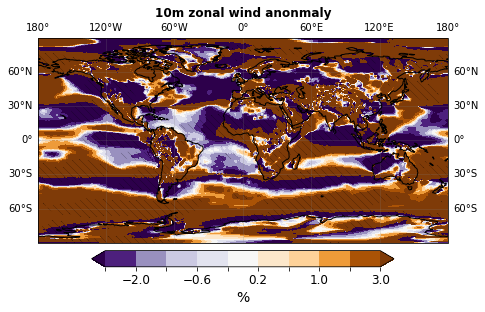

In [52]:
data_model = OrderedDict()
data_model_mean = OrderedDict()


for exp_name in input_names:
    data_model[exp_name] = np.squeeze(data[exp_name][variable[0]]) 
    data_model_mean[exp_name] = data_model[exp_name]
    if len(np.shape(data_model_mean[exp_name])) > 2:
        data_model_mean[exp_name] = np.mean(data_model_mean[exp_name],axis=0)
  

print(np.shape(data_model_mean[exp_name]))

for exp_name in input_names:
    lon = np.arange(0, 360, 0.5)
    lat = np.arange(-90, 90, 0.5)
    data_model_mean[exp_name], lon = add_cyclic_point(data_model_mean[exp_name], coord=lon)

print(np.shape(data_model_mean[exp_name]))


#rmsdval = rmsd(data_model_mean[exp_name],data_reanalysis_mean)
#mdval = md(data_model_mean[exp_name],data_reanalysis_mean)


nrows, ncol = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0


axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
axes[i].add_feature(cfeature.COASTLINE,zorder=3)


imf=plt.contourf(lon, lat, (data_model_mean[input_names[0]]-
                data_model_mean[input_names[1]])/data_model_mean[input_names[1]]*100, cmap=colormap, 
                 levels=levels, extend='both',
                 transform=ccrs.PlateCarree(),zorder=1)

plt.rcParams['hatch.linewidth']=0.15
cs = plt.contourf(lon, lat, data_sig, 3 , hatches=['\\\\\\', ''],  alpha=0)

line_colors = ['black' for l in imf.levels]


axes[i].set_ylabel('%')
axes[i].set_xlabel('Simulation Year')

axes[i].set_title(title,fontweight="bold")
plt.tight_layout() 
gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.2, linestyle='-')

gl.xlabels_bottom = False


cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
cbar_ax_abs.tick_params(labelsize=12)
cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=levels)
cb.set_label(label="%", size='14')
cb.ax.tick_params(labelsize='12')
#plt.text(5, 168, r'rmsd='+str(round(rmsdval,3)))
#plt.text(-7.5, 168, r'bias='+str(round(mdval,3)))
    
for label in cb.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

    
ofile=variable[0]+'_'+input_names[1]+'-'+input_names[0]+'_rel'
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')